# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

#### Описание данных
- Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
- Признаки
  - RowNumber — индекс строки в данных
  - CustomerId — уникальный идентификатор клиента
  - Surname — фамилия
  - CreditScore — кредитный рейтинг
  - Geography — страна проживания
  - Gender — пол
  - Age — возраст
  - Tenure — количество недвижимости у клиента
  - Balance — баланс на счёте
  - NumOfProducts — количество продуктов банка, используемых клиентом
  - HasCrCard — наличие кредитной карты
  - IsActiveMember — активность клиента
  - EstimatedSalary — предполагаемая зарплата
- Целевой признак
  - Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
#Подключим все необходимые библиотеки для нашего проекта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Откроем файл и Посмотрим как выглядит наш датасет
df = pd.read_csv('/datasets/Churn.csv')
display(df.head(5))
display(df.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [3]:
#Изучим наш датасет: посмотрим какие столбцы имеем, какие у них типы данных и посмотрим на количество строк в таблице
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
#Имеются ли пустые значения в датасете
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
#Посмотрим имеются ли у нас дубликаты 
df.duplicated().sum()

0

In [6]:
#Посмотрим на таблицу корреляции
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


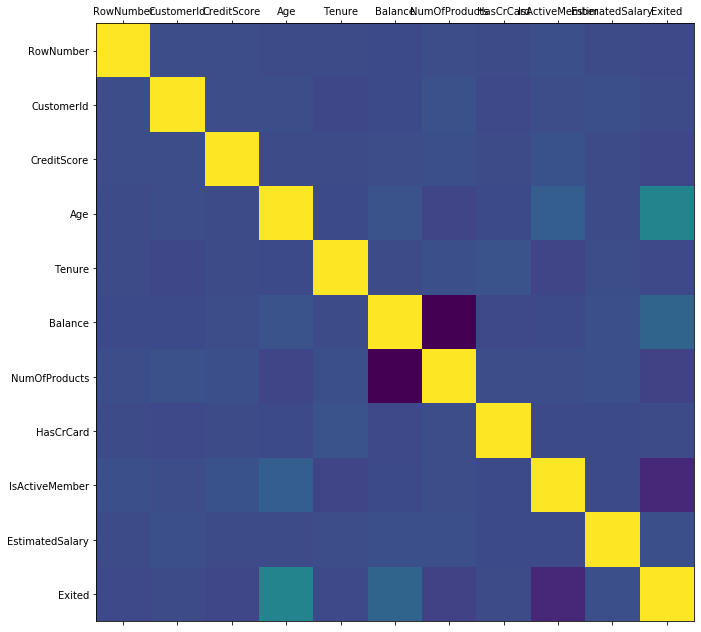

In [7]:
#Отрисуем матрицу корреляции
def plot_corr(df, size=11):
  corr = df.corr()
  fig, ax = plt.subplots(figsize=(size,size))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns)
  plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(df)

Как видим из графика взаимосвязей никаких нет. Ничего не будет мешать нашей будущей модели

In [8]:
#Выведем первые 5 строк
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
#Посмотрим методом value_counts сколько мужчин и женщин мы имеем
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [10]:
#Посмотрим на столбец география и его количество
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [11]:
#Удалим столбцы, которые не нужны будут для модели
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [12]:
#Еще раз выведем нашу таблицу
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [13]:
#Посчитаем количество пустых значений
df['Tenure'].isnull().sum()

909

In [14]:
#Изменим тип данных у столбца Tenure и заполним пустые значения с помощью SimpleImputer из библиотеки sklearn
df['Tenure'] = df['Tenure'].replace(np.NaN, None).astype(int,errors='ignore').astype(object)
imputer = SimpleImputer(strategy='constant')
imp_data = pd.DataFrame(imputer.fit_transform(df))
imp_data.columns = df.columns

#Проверим как сработал SimpleImputer
df['Tenure'].isnull().sum()

0

In [15]:
#Проведем кодирование с помощью OHE
df = pd.get_dummies(df, drop_first=True)

#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

In [16]:
df

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10
0,-0.326221,0.293517,-1.225848,1,1,1,0.021886,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.440036,0.198164,0.117350,1,0,1,0.216534,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,-1.536794,0.293517,1.333053,3,1,0,0.240687,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.501521,0.007457,-1.225848,2,0,0,-0.108918,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.063884,0.388871,0.785728,1,1,1,-0.365276,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,-1.225848,2,1,0,-0.066419,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9996,-1.391939,-0.373958,-0.306379,1,1,1,0.027988,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9997,0.604988,-0.278604,-1.225848,1,0,1,-1.008643,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,1.256835,0.293517,-0.022608,2,1,0,-0.125231,1,1,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
#С помощью train_test_split Разделим наш датасет на следующие выборки 
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Training set size:', X_train.shape[0])
print('Validating set size:', X_valid.shape[0])
print('Test set size:',X_test.shape[0])

Training set size: 6000
Validating set size: 2000
Test set size: 2000


### Вывод:
- Изучили наш датасет
    - Нашли пустые значения в столбце Tenure, заполнили их с помощью SimpleImputer
    - Дубликатов не выявили
    - Просмотрели матрицу корреляции, никаких взаимосвязей мещающих нашим будущим моделям не выявили
    - Провели кодирование и стандартизировали признаки с помощью StandardScaler
    - Разделили наш датасет на выборки : обучающую, валидационную и тестовую


# 2. Исследование задачи

In [18]:
# Модель RandomForestClassifier со стандартными параметрами, посмотрим какой аккураси и f1score покажет нам модель
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.8385
F1_Score is: 0.49922480620155035


array([[1516,   61],
       [ 262,  161]])

In [19]:
# Модель logisticRegression со стандартными параметрами, посмотрим какой аккураси и f1score покажет нам модель
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))

confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.789
F1_Score is: 0.2673611111111111


array([[1501,   76],
       [ 346,   77]])

<b>Определенно Случайный лес показывает наилучшие результаты, попробуем поработать с моделью Случайного леса, посмотрим удастся ли нам ее улучшить</b>

# 3. Борьба с дисбалансом

In [20]:
#Попробуем через цикл поиграть с параметрами случайного леса применив class_weight='balanced'
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1
Accuracy: 0.6785   |   F1_Score: 0.4819
------------------------------------------------------
Depth:     1       |   Estimators:    51
Accuracy: 0.7375   |   F1_Score: 0.4937
------------------------------------------------------
Depth:     1       |   Estimators:   101
Accuracy: 0.7345   |   F1_Score: 0.5238
------------------------------------------------------
Depth:    11       |   Estimators:     1
Accuracy: 0.7665   |   F1_Score: 0.5353
------------------------------------------------------
Depth:    11       |   Estimators:    51
Accuracy: 0.8350   |   F1_Score: 0.6034
------------------------------------------------------
Depth:    11       |   Estimators:   101
Accuracy: 0.8380   |   F1_Score: 0.6029
------------------------------------------------------
Depth:    21       |   Estimators:     1
Accuracy: 0.7605   |   F1_Score: 0.4437
------------------------------------------------------
Depth:    21       |   Estimators:    51
Accurac

<b>При глубине деревьев 11 и числе деревьев 51. F1_score показал наилучший результат : 0.6034 и accuracy_score : 0.8350. Попробуем улучшить показатели</b>

In [21]:
#Попробуем обучить нашу модель с помощью увеличения выборки

def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


for repeat in range(1,10,1):
    X_upsampled, y_upsampled = upsampling(X_train, y_train, repeat)

    model = RandomForestClassifier(random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions),repeat))

F1_Score: 0.496  |   Repeats :     1
F1_Score: 0.528  |   Repeats :     2
F1_Score: 0.506  |   Repeats :     3
F1_Score: 0.549  |   Repeats :     4
F1_Score: 0.533  |   Repeats :     5
F1_Score: 0.500  |   Repeats :     6
F1_Score: 0.524  |   Repeats :     7
F1_Score: 0.525  |   Repeats :     8
F1_Score: 0.526  |   Repeats :     9


In [22]:
#Попробуем обучить нашу модель с помощью уменьшения выборки

def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    X_downsampled, y_downsampled = downsampling(X_train, y_train, i)
    model = RandomForestClassifier(random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), i))

F1_Score: 0.374  |  Fractions : 0.030
F1_Score: 0.438  |  Fractions : 0.060
F1_Score: 0.473  |  Fractions : 0.090
F1_Score: 0.489  |  Fractions : 0.120
F1_Score: 0.503  |  Fractions : 0.150
F1_Score: 0.542  |  Fractions : 0.180
F1_Score: 0.535  |  Fractions : 0.210
F1_Score: 0.557  |  Fractions : 0.240
F1_Score: 0.534  |  Fractions : 0.270
F1_Score: 0.568  |  Fractions : 0.300


### Вывод: 
- Через цикл попробовали методом подбора количества деревьев и глубины леса подобрать нужные параметры. Выявили лучшие параметры это: глубина : 11, количество деревьев 51. F1 score показал 0.6034
- Попробовали улучшить модели путем увеличения и уменьшения выборок но увеличить f1_score не удалось. 

# 4. Тестирование модели

In [23]:
# Испробуем нашу модель на тестовой выборке с соответствующими параметрами
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_test, predicted_valid))

Accuracy is: 0.843
F1_Score is: 0.6244019138755981


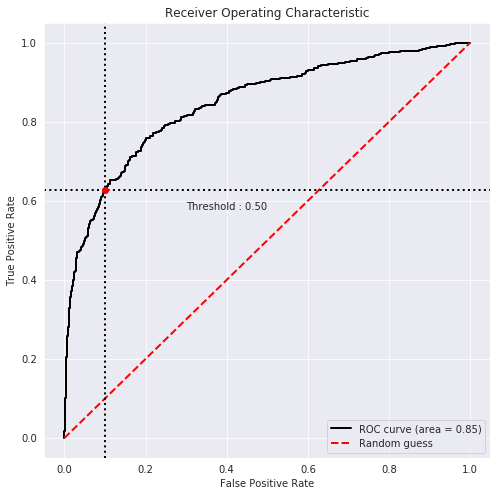

                       Roc Auc Score is: 0.847




In [24]:
#Отрисуем ROC Кривую
y_pred = model.predict_proba(X_test)[:,1]
bc = BinaryClassification(y_test, y_pred, labels=["Class 1"])

plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()
print('                       Roc Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print('\n')

### Общий вывод:
 - Подготовили датасет для прогнозирования оттока клиентов
 - Использовали две модели : RandomForestClassifier и LogisticRegression, на начальном этапе LogisticRegression показал наихудшие результаты, поэтому мы выбрали RandomForestClassifier для дальнейшей работы.
 - Попробовали увеличить и уменьшить выборки для увеличения f1_score, но наибольшее, что мы получили это f1_score : 0.56. Впринципе, требоваемое задание выполнили, но применив метод подбора количества деревьев и глубины леса через цикл мы нашли наилучшие параметры для Случайного Леса и получили F1_score : 0.62
 - Отрисовали ROC кривую и получили roc auc score : 85, что значительно больше случайного порога в 0.5. Наша модель предсказывает достаточно хорошо.


# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*